In [174]:
import re
import RAKE
from summa import keywords
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymorphy2 import MorphAnalyzer
from pymorphy2.tokenizers import simple_word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from yargy import Parser, rule, and_, or_
from yargy.predicates import gram, is_capitalized, dictionary
from yargy import Parser
from yargy.predicates import gram
from yargy.pipelines import morph_pipeline
from yargy.interpretation import fact
from IPython.display import display
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
# !pip install python-rake
# !pip install summa
# !pip install pymorphy2
# !pip install yargy

5 небольших текстов было взято с новостного портала https://www.dw.com, где ключевые слова представлены в конце статьи в виде "Ключевые слова: ключевое слово1, ключевое слово2, ...". На этом сайте ключевых слов представлено достаточно много (примерно от 5 и больше слов), что представляется удобным и информативным.

Ниже представлена табличка с текстами, ключевыми словами с сайта (keywords), ключевыми словами, добавленными мной (my_keywords), эталонными ключевыми словами, которые составляют **объединение** моих и изначальных ключевых слов (standart). В целом, на сайте ключевые слова достаточно хорошо размечены, поэтому я добавила совсем немного своих (в основном названия стран, лица, прил+сущ).

In [132]:
df = pd.read_csv('corpus.csv', sep=';', encoding='utf-8')
df

,text,keywords,my_keywords,standart
0,"Хористы из трех стран споют в Москве ""Братское...","Александр Кастальский, Братское поминовение, М...","хоровые коллективы, Александр Кастальский, Пер...","Александр Кастальский, Братское поминовение, М..."
1,"Праздники в Германии проходят под знаком ""Щелк...","Щелкунчик, театральная афиша, Германия, Чайков...","праздники, опера, Германия, популярная классик...","Щелкунчик, театральная афиша, Германия, Чайков..."
2,Во Франкфурте показывают искусство гламурной ф...,"глянцевая фотография, папарацци, выставка, Фра...","папарацци, выставка, Schirn, глянцевая фотогра...","глянцевая фотография, папарацци, выставка, Фра..."
3,В Германии построили Третьяковку (фото)\nКирпи...,"Третьяковская галерея, выставка в Третьяковке,...","Германия, Новая Третьяковка, кирпичики LEGO, е...","Третьяковская галерея, выставка в Третьяковке,..."
4,Центр авангарда поможет россиянам стать толера...,"Еврейский музей и центр толерантности, авангар...","Еврейский музей , центр толерантности, новая п...","авангард, искусство, толерантность, минкульт, ..."


Функции для обработки текстов и для выведения метрик по каждому методу.

In [133]:
m = MorphAnalyzer()
def normalize_text(text):
    lemmas = []
    for t in simple_word_tokenize(text):
        lemmas.append(
            m.parse(t)[0].normal_form
        )
    string = ' '.join(lemmas)
    return string

In [166]:
def get_scores(predicted_keywords, method):
  sum_accuracy = 0
  sum_fullness = 0
  for num in range(0, 5):
    predicted = predicted_keywords[num]
    raw_kw = normalize_text(df['standart'][num]).split(',')
    standart = []
    for item in raw_kw:
      item = item.strip()
      standart.append(item)
    both = list(set(predicted) & set(standart))
    accuracy = len(both) / len(predicted)
    fullness = len(both) / len(standart)
    sum_accuracy += accuracy
    sum_fullness += fullness
  average_accuracy = sum_accuracy / 5
  average_fullness = sum_fullness / 5
  f_score = 2 * average_accuracy * average_fullness / (average_accuracy + average_fullness)
  return 'точность ' + str(method) + ':', round(average_accuracy, 3), \
  'полнота ' + str(method) + ':', round(average_fullness, 3), \
  'f-мера ' + str(method) + ':', round(f_score, 3)

Общее количество токенов (с пунктуацией) составило 8263 ед.

In [135]:
average_len = 0
for text in range(0, len(df)):
  average_len += len(normalize_text(df['text'][text]))
print(average_len)

8263


#### RAKE

In [136]:
rake = RAKE.Rake(stop)

In [137]:
kw_rake = []

In [138]:
for num in range(0, 5):
  kw_list_rake = rake.run(normalize_text(df['text'][num]), maxWords=3, minFrequency=2)
  kw_list_rake = [item[0] for item in kw_list_rake]
  kw_rake.append(kw_list_rake)

In [139]:
for text in range(0, len(kw_rake)):
  print('keywords for text №' + str(text+1), kw_rake[text])

keywords for text №1 ['хоровой коллектив', 'братский поминовение', 'москва', 'германия', 'россия', 'память']
keywords for text №2 ['щелкунчик']
keywords for text №3 ['папарацци', 'фотограф', 'звезда', 'снимок']
keywords for text №4 ['из-', 'москва', 'берлин', 'париж']
keywords for text №5 ['энциклопедия русский авангард', 'центр авангард', 'центр толерантность', 'еврейский музей', 'нечто враждебный', 'авангард', 'который']


In [167]:
get_scores(kw_rake, 'RAKE')

('точность RAKE:', 0.648, 'полнота RAKE:', 0.256, 'f-мера RAKE:', 0.367)

#### TextRank

In [141]:
kw_textrank = []

In [142]:
for num in range(0, 5):
  kw_list_tr = keywords.keywords(normalize_text(df['text'][num]), language='russian', additional_stopwords=stop, scores=True)
  kw_list_tr = [item[0] for item in kw_list_tr]
  kw_textrank.append(kw_list_tr)

In [143]:
for text in range(0, len(kw_textrank)):
  print('keywords for text №' + str(text+1), kw_textrank[text])

keywords for text №1 ['московский', 'первый', 'это', 'братский поминовение', 'александр кастальский', 'хор', 'совместно', 'совместный', 'война', 'филармония', 'исполнить сочинение', 'страна']
keywords for text №2 ['щелкунчик', 'опера', 'часто', 'часть', 'афиша', 'театр', 'информационный агентство', 'праздник', 'делать', 'классика', 'энгельбердт', 'humperdinck']
keywords for text №3 ['выставка', 'музей', 'фотограф', 'работа', 'фотография папарацци', 'который', 'также', 'пэрис', 'искусство', 'schirn', 'художник', 'жизнь', 'кеннеди', 'принцесса', 'звезда', 'являться', 'бруно', 'шерман', 'dpa', 'спирс', 'визуальный', 'жёлтый', 'ростэн', 'герхард']
keywords for text №4 ['стена', 'искусство', 'lego', 'куратор передвижной выставка', 'мочь', 'произведение', 'готовить экспозиция', 'построить третьяковка', 'показать', 'работа', 'модель новый', 'метр', 'третьяковский']
keywords for text №5 ['центр авангард', 'автор', 'деятельность', 'проект', 'стать толерантный', 'новый', 'толерантность', 'которы

In [168]:
get_scores(kw_textrank, 'TextRank')

('точность TextRank:',
 0.122,
 'полнота TextRank:',
 0.174,
 'f-мера TextRank:',
 0.144)

#### TF-IDF

In [145]:
def sort_coo(coo_matrix):
    """Sort a dict with highest score"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results


def get_keywords(vectorizer, feature_names, doc):
    tf_idf_vector = vectorizer.transform([doc])
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,15)
    return list(keywords.keys())

In [146]:
all_texts = ''
for i in range(0, len(df['text'])):
  all_texts += df['text'][i]
vectorizer = TfidfVectorizer(stop_words=stop, smooth_idf=True, ngram_range=(1,3))
vectorizer.fit_transform([normalize_text(all_texts)])
feature_names = vectorizer.get_feature_names()

In [147]:
kw_tfidf = []
for num in range(0, 5):
  kw_list_tfidf = get_keywords(vectorizer, feature_names, normalize_text(df['text'][num]))
  kw_tfidf.append(kw_list_tfidf)

In [148]:
for text in range(0, len(kw_tfidf)):
  print('keywords for text №' + str(text+1), kw_textrank[text])

keywords for text №1 ['московский', 'первый', 'это', 'братский поминовение', 'александр кастальский', 'хор', 'совместно', 'совместный', 'война', 'филармония', 'исполнить сочинение', 'страна']
keywords for text №2 ['щелкунчик', 'опера', 'часто', 'часть', 'афиша', 'театр', 'информационный агентство', 'праздник', 'делать', 'классика', 'энгельбердт', 'humperdinck']
keywords for text №3 ['выставка', 'музей', 'фотограф', 'работа', 'фотография папарацци', 'который', 'также', 'пэрис', 'искусство', 'schirn', 'художник', 'жизнь', 'кеннеди', 'принцесса', 'звезда', 'являться', 'бруно', 'шерман', 'dpa', 'спирс', 'визуальный', 'жёлтый', 'ростэн', 'герхард']
keywords for text №4 ['стена', 'искусство', 'lego', 'куратор передвижной выставка', 'мочь', 'произведение', 'готовить экспозиция', 'построить третьяковка', 'показать', 'работа', 'модель новый', 'метр', 'третьяковский']
keywords for text №5 ['центр авангард', 'автор', 'деятельность', 'проект', 'стать толерантный', 'новый', 'толерантность', 'которы

In [169]:
get_scores(kw_tfidf, 'TF-IDF')

('точность TF-IDF:', 0.213, 'полнота TF-IDF:', 0.302, 'f-мера TF-IDF:', 0.25)

Теперь вернемся к эталонным ключевым словам и посмотрим на синтаксические/морфологические паттерны. 

In [150]:
for row in range(0, len(df)):
  print(df['standart'][row])

Александр Кастальский, Братское поминовение, Московская филармония, хоровые коллективы, Figuralchor, Первая мировая война, Россия, Австрия, Германия, воплощение замысла
Щелкунчик, театральная афиша, Германия, Чайковский, Моцарт, Хумпердинк, опера, Рождество, праздники, популярная классика, афиша
глянцевая фотография, папарацци, выставка, Франкфурт-на-Майне, Schirn, Пэрис Хилтон, Бритни Спирс, шоу-бизнес, принцесса Диана, Джеки Кеннеди-Онассис, репортеры
Третьяковская галерея, выставка в Третьяковке, выставка в Москве, Европейские художники, Diversity United, миниатюрный музей, Новая Третьяковка, кирпичики LEGO, Германия, Новая Третьяковка, миниатюрная модель, Бонн, Москва, Берлин, Париж
авангард, искусство, толерантность, минкульт, Еврейский музей , центр толерантности, новая программа, Энциклопедия русского авангарда


Что характерно для ключевых слов:
*   Noun + Noun
*   Adj + Noun
*   Adj + Adj + Noun
*   Noun
*   Noun + Noun + Noun (имена, названия)
*   слова на латинице (города, названия)
*   N + Adj (так распознаются например имена собственные с фамилиями на -ий)




In [151]:
Name = fact(
    'Name',
    ['first', 'last']
)
NAME = rule(
    gram('Name').interpretation(
        Name.first.inflected()
    ),
    gram('Surn').interpretation(
        Name.last.inflected()
    )
).interpretation(
    Name
)
NP = rule(gram('NOUN'), gram('NOUN'))
AdjP = rule(gram('ADJF'), gram('NOUN'))
AdjAdjP = rule(gram('ADJF'), gram('ADJF'), gram('NOUN'))
NNP = rule(gram('NOUN'), gram('NOUN'), gram('NOUN'))
N = rule(gram('NOUN'))
PAdj = rule(gram('NOUN'), gram('ADJF'))


grammar = Parser(
    or_(
        NAME,
        NP,
        AdjP,
        AdjAdjP,
        NNP,
        N,
        PAdj
    )
)

In [152]:
def filtering(kw_set):
  new_kw = []
  for kw in kw_set:
    if kw.isascii():
      new_kw.append(kw)
    for match in grammar.findall(kw):
      new_keyword = ' '.join([_.value for _ in match.tokens])
      new_kw.append(new_keyword)
  return new_kw


def get_new_keywords(predicted_keywords):
  new_predicted_kw = []
  for kw_set in predicted_keywords:
    new_predicted_kw.append(filtering(kw_set))
  return new_predicted_kw

In [153]:
new_kw_rake = get_new_keywords(kw_rake)
new_kw_textrank = get_new_keywords(kw_textrank)
new_kw_tfidf = get_new_keywords(kw_tfidf)

Посмотрим что получилось после фильтрации по заданным шаблонам.

In [154]:
for text in range(0, len(new_kw_tfidf)):
  print('RAKE keywords for text №' + str(text+1), new_kw_rake[text])
print('------')
for text in range(0, len(new_kw_tfidf)):
  print('TextRank keywords for text №' + str(text+1), new_kw_textrank[text])
print('------')
for text in range(0, len(new_kw_tfidf)):
  print('TF-IDF keywords for text №' + str(text+1), new_kw_tfidf[text])

RAKE keywords for text №1 ['хоровой коллектив', 'братский поминовение', 'москва', 'германия', 'россия', 'память']
RAKE keywords for text №2 ['щелкунчик']
RAKE keywords for text №3 ['папарацци', 'фотограф', 'звезда', 'снимок']
RAKE keywords for text №4 ['из', 'москва', 'берлин', 'париж']
RAKE keywords for text №5 ['энциклопедия русский', 'авангард', 'центр авангард', 'центр толерантность', 'еврейский музей', 'авангард']
------
TextRank keywords for text №1 ['московский', 'братский поминовение', 'александр кастальский', 'хор', 'война', 'филармония', 'сочинение', 'страна']
TextRank keywords for text №2 ['щелкунчик', 'опера', 'часть', 'афиша', 'театр', 'информационный агентство', 'праздник', 'классика', 'энгельбердт', 'humperdinck']
TextRank keywords for text №3 ['выставка', 'музей', 'фотограф', 'работа', 'фотография папарацци', 'пэрис', 'искусство', 'schirn', 'художник', 'жизнь', 'кеннеди', 'принцесса', 'звезда', 'бруно', 'шерман', 'dpa', 'спирс', 'ростэн', 'герхард']
TextRank keywords fo

Посмотрим на результаты метрик с примененными шаблонами.

In [170]:
get_scores(new_kw_rake, 'RAKE')

('точность RAKE:', 0.633, 'полнота RAKE:', 0.231, 'f-мера RAKE:', 0.339)

In [171]:
get_scores(new_kw_textrank, 'TextRank')

('точность TextRank:',
 0.16,
 'полнота TextRank:',
 0.174,
 'f-мера TextRank:',
 0.167)

In [172]:
get_scores(new_kw_tfidf, 'TF-IDF')

('точность TF-IDF:', 0.252, 'полнота TF-IDF:', 0.302, 'f-мера TF-IDF:', 0.275)

Для красоты визуализировала результаты по всем методам.
1) Полнота 2) Точность 3) F-мера

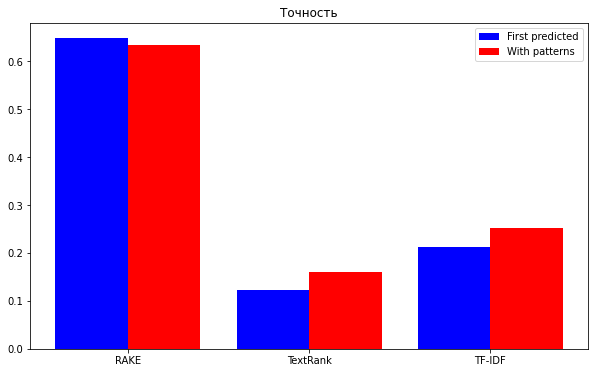

In [181]:
fig = plt.figure(figsize=(10, 6))

X = ['RAKE', 'TextRank', 'TF-IDF']
xmaes = [get_scores(kw_rake, 'RAKE')[1], get_scores(kw_textrank, 'TextRank')[1], get_scores(kw_tfidf, 'TF-IDF')[1]]
yrmses = [get_scores(new_kw_rake, 'RAKE')[1], get_scores(new_kw_textrank, 'TextRank')[1], get_scores(new_kw_tfidf, 'TF-IDF')[1]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, xmaes, 0.4, color = 'b', label = 'First predicted')
plt.bar(X_axis + 0.2, yrmses, 0.4, color = 'r', label = 'With patterns')
  
plt.xticks(X_axis, X)
plt.title("Точность")
plt.legend()
plt.show()

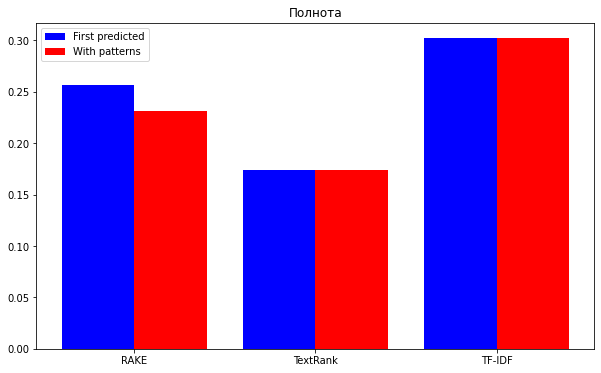

In [182]:
fig = plt.figure(figsize=(10, 6))

X = ['RAKE', 'TextRank', 'TF-IDF']
xmaes = [get_scores(kw_rake, 'RAKE')[3], get_scores(kw_textrank, 'TextRank')[3], get_scores(kw_tfidf, 'TF-IDF')[3]]
yrmses = [get_scores(new_kw_rake, 'RAKE')[3], get_scores(new_kw_textrank, 'TextRank')[3], get_scores(new_kw_tfidf, 'TF-IDF')[3]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, xmaes, 0.4, color = 'b', label = 'First predicted')
plt.bar(X_axis + 0.2, yrmses, 0.4, color = 'r', label = 'With patterns')
  
plt.xticks(X_axis, X)
plt.title("Полнота")
plt.legend()
plt.show()

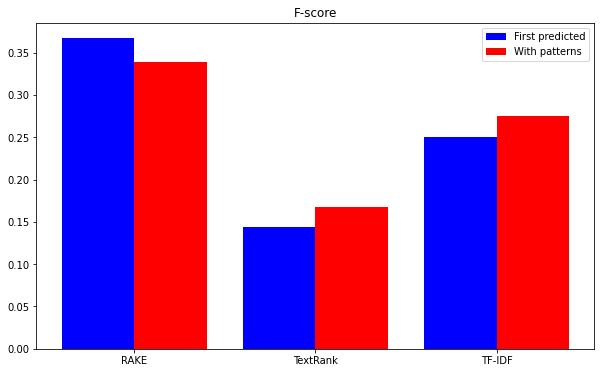

In [183]:
fig = plt.figure(figsize=(10, 6))

X = ['RAKE', 'TextRank', 'TF-IDF']
xmaes = [get_scores(kw_rake, 'RAKE')[5], get_scores(kw_textrank, 'TextRank')[5], get_scores(kw_tfidf, 'TF-IDF')[5]]
yrmses = [get_scores(new_kw_rake, 'RAKE')[5], get_scores(new_kw_textrank, 'TextRank')[5], get_scores(new_kw_tfidf, 'TF-IDF')[5]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, xmaes, 0.4, color = 'b', label = 'First predicted')
plt.bar(X_axis + 0.2, yrmses, 0.4, color = 'r', label = 'With patterns')
  
plt.xticks(X_axis, X)
plt.title("F-score")
plt.legend()
plt.show()

#### Выводы




1.  **Результаты метрик**: применение шаблонов не дало лучших результатов (в случае RAKE они даже стали хуже). В целом из всех методов лучше всех с выделением ключевых слов справился RAKE. Применение шаблонов представилось достаточно трудной задачей, потому что в текстах встречаются длинные ключевые слова (например, "Энциклопедия русского авангарда"), которые в себе содержат несколько именных групп. По этой причине мне пришлось выделить наиболее общие паттерны, а уникальные случаи с перстановкой слов и большим кол-во слов пришлось исключить (именнно из-за этого и упали результаты в RAKE). В целом можно решить эту проблему упрощением ключевых слов или добавлением большего кол-ва правил для шаблонов.

2.   **Ошибки автоматического выделения ключевых слов**: 

*   Наиболее распростаненные ключевые слова -- существительные. Но проблема в том, что методы не различают именованные и обычные сущ-е, из-за чего иногда всплывают лишние ключевые слова, а нужные имена и названия не выделяются. + проблема имен (брать полные или только фамилию? непонятно).
*   По всей видимости, ключевые слова тяготеют к упрощению и обобщению информации. Ни один метод не извлек ключевые слова вида "событие на месте". Более популярны все-таки теги, тк они как раз и являются обобщением. Ключевые слова же берутся из текста и часто могут не соответствовать автоматическому извлечению. Тут нужно скорее всего поиграться со словами, сделать их проще и меньше по количеству. 



